# Exploration 5. 닮은 얼굴 이미지 찾기  Face Embedding, Similarity

여러 사람을 만나다보면 한번씩 이런 생각을 해본 적 있을 것이다.

_" 어... 누구 닮았는데?"_

사람은 다른 사람 얼굴을 볼 때 쉽게 닮은 사람을 떠올리거나 찾아낼 수 있다.

또 어떤 유명인의 닮은 꼴 사진을 보고 피식 웃기도 한다.

![image](https://user-images.githubusercontent.com/84179578/127099419-b21d9649-296a-4df3-a27a-b7f33f5bcc2e.png)


그렇다면 과연 컴퓨터도 이미지 데이터를 받아서 이렇게 닮은 꼴을 찾아낼 수 있을까?  
.  

.  

.  

_그렇다 ! 컴퓨터도 여러 과정을 통해 닮은 얼굴의 이미지를 찾아낼 수 있다._

그 과정을 간략하게 보면
- 얼굴 영역만 인식해서 추출
- 고차원의 이미지 벡터를 저차원의 벡터로 변환하면서 필요한 정보는 보존하는 __임베딩(Embedding)__ 
- 얼굴 임베딩 벡터 사이의 거리가 두 얼굴이 얼마나 닮았나를 반영

개념적인 부분의 내용은 아래의 블로그 링크를 참조.
> 블로그 링크 추가 예정

그럼 간단하게 미국 대통령 사진을 통해 위의 과정을 실제로 진행해보자.

## 1. 데이터 준비

먼저 샘플 이미지들을 가져와서 `matplotlib` 로 확인해보자.

file_list: ['clinton.jpeg', 'trump.jpg', 'biden.jpg', 'bush.jpeg', 'obama.jpg', 'reagan.jpg']


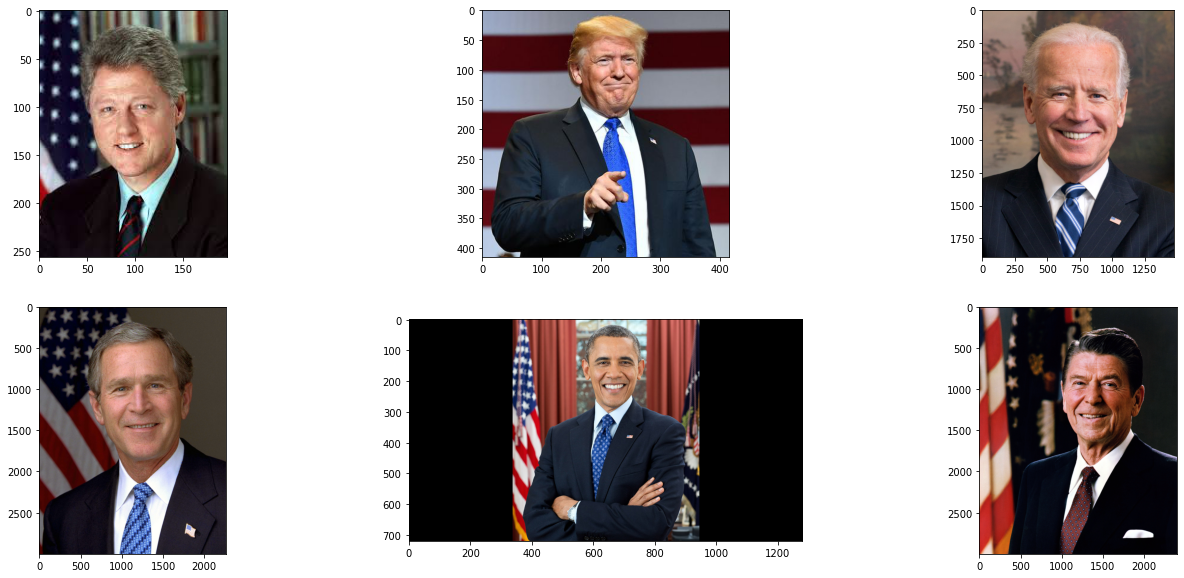

In [1]:
import os
import numpy as np


dir_path = 'EP05_data_1'
file_list = os.listdir(dir_path)

print ("file_list: {}".format(file_list))

import matplotlib.pyplot as plt
import matplotlib.image as img

#Set figsize here
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24,10))

# flatten axes for easy iterating
for i, ax in enumerate(axes.flatten()):
  image = img.imread(dir_path+'/'+file_list[i])
  ax.imshow(image)
plt.show()

fig.tight_layout()

`face_recognition.face_locations` 를 사용해 얼굴 영역을 찾고 얼굴 영역만 자르자.

예시로 `obama.jpg` 를 불러온 후 위 과정을 진행했다.

[(98, 758, 284, 572)]


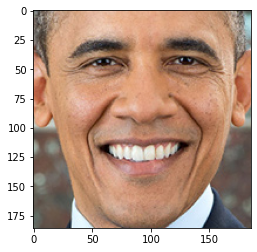

In [2]:
import face_recognition
import os
%matplotlib inline
import matplotlib.pyplot as plt

image_path = 'EP05_data_1/obama.jpg'
image = face_recognition.load_image_file(image_path)
face_locations = face_recognition.face_locations(image)

print(face_locations)  # 이미지에서 얼굴 영역의 좌표를 출력합니다.

a, b, c, d = face_locations[0]
cropped_face = image[a:c,d:b,:]

plt.imshow(cropped_face)   # 이미지에서 얼굴영역만 잘라낸 cropped_face를 그려 봅니다.

얼굴 영역만 잘라서 정확하게 가져오는 것을 확인 할 수 있다.

위 과정을 응용하여 이미지 파일 경로를 파라미터로 넘기면 얼굴 영역만 자르는 `get_cropped_face()` 함수를 만들겠다.  

In [3]:
def get_cropped_face(image_file):
    image = face_recognition.load_image_file(image_file)
    face_locations = face_recognition.face_locations(image)

    a, b, c, d = face_locations[0]
    cropped_face = image[a:c,d:b,:]
    
    return cropped_face

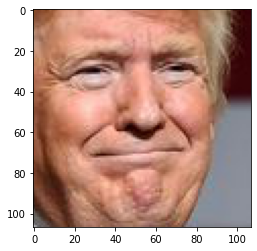

In [4]:
# test 코드
image_path = 'EP05_data_1/trump.jpg'

cropped_face = get_cropped_face(image_path)
plt.imshow(cropped_face)

`get_cropped_face()` 를 통해 얼굴 영역이 잘 가져와지는 것을 확인 할 수 있다.

`Face Recognition` 패키지에서 제공하는 얼굴 임베딩 벡터를 구하는 함수는 `face_recognition.face_encodings()` 이다.  

이것을 이용해서 얼굴영역을 가지고 얼굴 임베딩 벡터를 구하는 `get_face_embedding` 를 정의하자.

In [5]:
image_file = os.path.join(dir_path, 'obama.jpg')
face = get_cropped_face(image_file)   # 얼굴 영역을 구하는 함수(이전 스텝에서 구현)

# 얼굴 영역을 가지고 얼굴 임베딩 벡터를 구하는 함수
def get_face_embedding(face):
    return face_recognition.face_encodings(face)

embedding = get_face_embedding(face)  
embedding

[array([-0.08126248,  0.11014761, -0.01082448, -0.05268792,  0.01033717,
        -0.00813808, -0.07251769, -0.0922646 ,  0.19304723, -0.09246384,
         0.23908533,  0.06770287, -0.22123125, -0.14119367,  0.05562152,
         0.13705511, -0.17924425, -0.07232306, -0.11183281, -0.11370818,
         0.03956435, -0.01019115,  0.0942178 ,  0.04493114, -0.12757549,
        -0.34449592, -0.05374938, -0.17703305,  0.00868226, -0.09721592,
        -0.09817187,  0.00278232, -0.17721367, -0.12789807,  0.03489833,
        -0.01991234, -0.00838933, -0.00132862,  0.18308581,  0.02447568,
        -0.1237656 ,  0.09957044,  0.02323568,  0.22983313,  0.2838524 ,
         0.06655717, -0.00558912, -0.09833544,  0.10058986, -0.23476946,
         0.06006292,  0.1341591 ,  0.08373027,  0.03900504,  0.10194533,
        -0.19337648,  0.01717628,  0.08978969, -0.16005114,  0.01892098,
         0.03082444, -0.06051281, -0.04526773,  0.04633342,  0.20678686,
         0.10299795, -0.12437531, -0.0490516 ,  0.1

이제 `EP05_data_1` 디렉토리 안에 있는 모든 이미지 파일의 얼굴 임베딩을 구해서 딕셔너리 구조에 담아 리턴하는 `get_face_embedding_dict()` 함수를 만들자.  

이때, 딕셔너리의 각 요소는 `사람 이름 : 임베딩 벡터` 로 하겠다.

In [6]:
def get_face_embedding_dict(dir_path):
    file_list = os.listdir(dir_path)
    embedding_dict = {}
    
    for file in file_list:
        img_path = f'{dir_path}/{file}'
        face = get_cropped_face(img_path)
        embedding = get_face_embedding(face)
        if len(embedding) > 0:  
        # 얼굴영역 face가 제대로 detect되지 않으면  len(embedding)==0인 경우가 발생하므로 
        # os.path.splitext(file)[0]에는 이미지파일명에서 확장자를 제거한 이름이 담깁니다. 
            embedding_dict[os.path.splitext(file)[0]] = embedding[0]
        
    return embedding_dict

In [7]:
embedding_dict = get_face_embedding_dict(dir_path)
embedding_dict['trump']

array([-0.15962467,  0.20268655,  0.0323635 ,  0.02439232, -0.06226439,
        0.05140705,  0.07351795, -0.16823348,  0.06962204, -0.05557961,
        0.17270109, -0.05094168, -0.35293093, -0.0316438 ,  0.03792984,
        0.17343847, -0.13260126, -0.15357377, -0.23523533, -0.08442692,
       -0.00134139,  0.03210667, -0.08926154, -0.02670781, -0.09581181,
       -0.25792354, -0.01056999, -0.11071672,  0.03133569, -0.07444921,
        0.05670552, -0.02273796, -0.19461137, -0.04576054,  0.00947582,
        0.01806056, -0.1502624 , -0.07787319,  0.17577608,  0.01933258,
       -0.19744575, -0.03930519,  0.07374467,  0.20196027,  0.1476755 ,
       -0.0141539 ,  0.0172476 , -0.11976205,  0.09462971, -0.24318144,
       -0.02755127,  0.12169892,  0.14837705,  0.17079785,  0.06952555,
       -0.15360466,  0.02005427,  0.08199155, -0.19544823,  0.10653654,
        0.11468476, -0.21902837, -0.07677591, -0.06791042,  0.10587606,
        0.05921567, -0.06115703, -0.11171092,  0.23917492, -0.15

`get_face_embedding_dict()` 함수가 잘 동작하는 것을 확인 할 수 있다.

다음으로 얼굴이 얼마나 닮은지 판단하기위해  얼굴임베딩 벡터 사이의 거리를 구해야한다.

인자로 파일명의 사람 이름 2개를 받아서, 두 사람의 얼굴 임베딩 사이의 거리(L2 distance)를 구하는 `get_distance()` 함수를 만들자.

In [8]:
def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)

get_distance('obama', 'trump')

0.8885117374787042

지금까지 구현한 함수를 정리하면 다음과 같다.
- `get_cropped_face(image_file)` : 이미지 파일에서 얼굴 영역을 가져오는 함수

- `get_face_embedding(face)` : 얼굴영역으로부터 얼굴 임베딩 벡터를 구하는 함수
- `get_face_embedding_dict(dir_path)` : 디렉토리 안에 있는 모든 이미지의 임베딩 딕셔너리를 구하는 함수
- `get_distance(name1, name2)` : 두 이미지(사람 이름) 사이의 임베딩 벡터 거리를 구하는 함수

name1과 name2의 거리를 비교하는 `get_sort_key_func()`함수를 만들자.  

이때, name1은 미리 지정하고, name2는 호출시에 인자로 받도록 하겠다.

In [9]:
def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2)
    return get_distance_from_name1

sort_key_func = get_sort_key_func('trump')   

이렇게 생성된 함수 `sort_key_func` 는 `sort_key_func('obama')` 라고 호출할 때 `trump`와 `obama` 사이의 임베딩 벡터 거리를 계산한다.

최종적으로, 이제 입력받은 임의의 이름에 대해 다른 이미지의 임베딩 거리를 정렬해서 출력하는 `get_nearest_face()` 를 만들자.

In [10]:
def get_nearest_face(name, top=5):
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    
    for i in range(top+1):
        if i == 0 :   # 첫번째로 나오는 이름은 자기 자신일 것이므로 제외
            continue
        if sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(i, sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))

In [11]:
get_nearest_face('obama')

순위 1 : 이름(biden), 거리(0.846720652777963)
순위 2 : 이름(bush), 거리(0.8639189288560225)
순위 3 : 이름(reagan), 거리(0.8692435806803928)
순위 4 : 이름(trump), 거리(0.8885117374787042)
순위 5 : 이름(clinton), 거리(0.9000994624487408)


이렇게 얼굴 이미지를 임베딩 벡터로 변환하여 임베딩 벡터 사이 거리가 작은 순대로 정렬함으로써 가장 닮은 이미지를 찾을 수 있다.